# Bayesian Linear Regression with Bambi

https://towardsdatascience.com/bayesian-linear-regression-with-bambi-a5e6570f167b

##### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import bambi as bmb

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


##### Import kaggle data from github repo. Data includes scores from Math and Portugese

In [2]:
df = pd.read_csv(
    "https://media.githubusercontent.com/media/khuyentran1401/Data-science"
    "/master/statistics/bayes_linear_regression/student-score.csv"
)

df.head(10)

,mat,por
0,5,0
1,5,9
2,7,12
3,15,14
4,6,11
5,15,12
6,12,13
7,6,10
8,16,15
9,14,12


##### Graph relationship between data

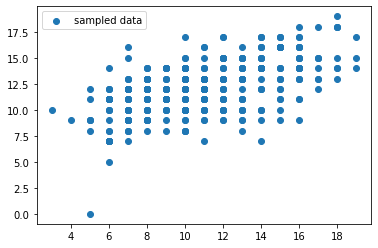

In [3]:
mat, por = df["mat"].values, df["por"].values

plt.scatter(mat, por, label="sampled data")
plt.legend(loc=0)

##### Run Linear Regression and fit to data

In [4]:
linear_model = LinearRegression().fit(mat.reshape(-1, 1), por)
predict_line = linear_model.predict(mat.reshape(-1, 1))

##### Graph linear regression line

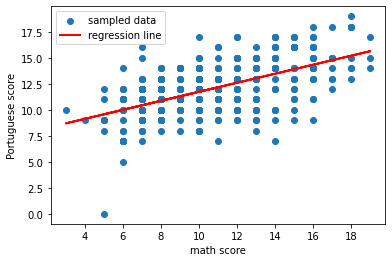

In [5]:
plt.scatter(mat, por, label="sampled data")
plt.plot(mat, predict_line, label="regression line", lw=2.0, color="red")
plt.xlabel("math score")
plt.ylabel("Portuguese score")
plt.legend(loc=0)

##### What are the regression coeficients and intercepts

In [6]:
print("Linear Regression Coefficient: ",linear_model.coef_)
print("Linear Regression Intercept: ",linear_model.intercept_)

Linear Regression Coefficient:  [0.4335796]
Linear Regression Intercept:  7.403346211071997


##### Run Gaussian Model

In [7]:
gauss_model = bmb.Model('por ~ mat', data=df)

##### Fit Gaussian Model

In [8]:
%%time
# Fit the model using 1000 on each of 4 chains
gauss_fitted = gauss_model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, mat, por_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


CPU times: total: 27.4 s
Wall time: 9 s


##### Predict on Gaussian model

In [9]:
%%time
gauss_model.predict(gauss_fitted, kind="pps")

CPU times: total: 125 ms
Wall time: 46 ms


##### Graph distribution of intercept & coefficient as well as the value of each variable in each iteration

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'mat'}>,
        <AxesSubplot:title={'center':'mat'}>]], dtype=object)

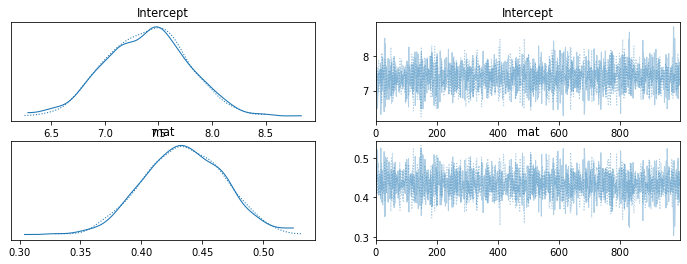

In [11]:
import arviz as az

az.plot_trace(gauss_fitted, var_names=["Intercept", "mat"])

##### Compare results of Bayesian Linear Regression and OLS

In [12]:
print("The Bayesian Regression coefficient: ",gauss_fitted.posterior.mat.values.mean())
print("The Bayesian Regression intercept: ",gauss_fitted.posterior.Intercept.values.mean())

The Bayesian Regression coefficient:  0.43456640766406796
The Bayesian Regression intercept:  7.389921898723891


Coefficient:  0.4336 vs 0.4341 <br>
Intercept:  7.4033 vs 7.3951

##### Plot Regression Lines - 4000 samples total. For each pair of coef & int we get a y. These are only 100 predictions.

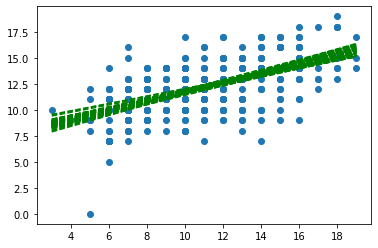

In [13]:
# plot data
plt.scatter(mat,por,label="data")

# Value of x-axis
x_range = np.linspace(min(mat),max(mat),2000)

# Plot sample predictions
for i in range(100):
    y_pred = (gauss_fitted.posterior.mat.values[0,i]*x_range
             + gauss_fitted.posterior.Intercept.values[0,i])
    plt.plot(x_range,y_pred,
            color="green",linestyle="--",
            label="Mean regression line"
            )

##### Use the mean of the coef & int to get a single esitmate of y

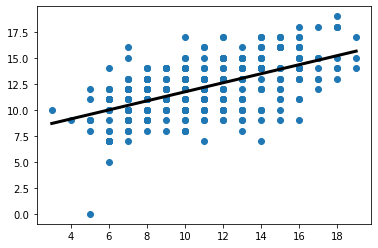

In [14]:
# Plot Data
plt.scatter(mat, por, label="data")

# Values of x-axis
x_range = np.linspace(min(mat), max(mat), 2000)

y_pred = gauss_fitted.posterior.mat.values.mean() * x_range + gauss_fitted.posterior.Intercept.values.mean()

# Plot mean prediction    
plt.plot(x_range, y_pred,
        color="black",
        label="Mean regression line",
        linewidth = 3
        )

##### Plot distributions of all predictions - compare individual predictions with the mean - from below you can see the orangle line is a good representation of the black line

<AxesSubplot:xlabel='por / por'>

C:\Users\wallj\anaconda3\envs\pymc4\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


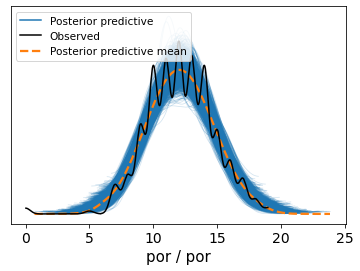

In [15]:
az.plot_ppc(gauss_fitted)

##### What are the most common predictions for a particular value of x? Plot highest density interval of the predictions. HDI = high density interval

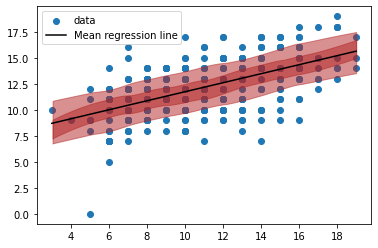

In [15]:
# Plot Data
plt.scatter(mat, por, label="data")

x_range = np.linspace(min(mat), max(mat), 2000)
y_pred = gauss_fitted.posterior.mat.values.mean() * x_range + gauss_fitted.posterior.Intercept.values.mean()

# Plot mean prediction  
plt.plot(x_range, y_pred,color="black", label="Mean regression line")
        
# Plot HDIs
for interval in [0.33, 0.66]:
    az.plot_hdi(mat, gauss_fitted.posterior_predictive.por,
                hdi_prob=interval, color="firebrick")

plt.legend(loc=0);

***
***
***